Number of columns before filtering: 123
Number of columns after filtering: 72


<Figure size 3800x9800 with 0 Axes>

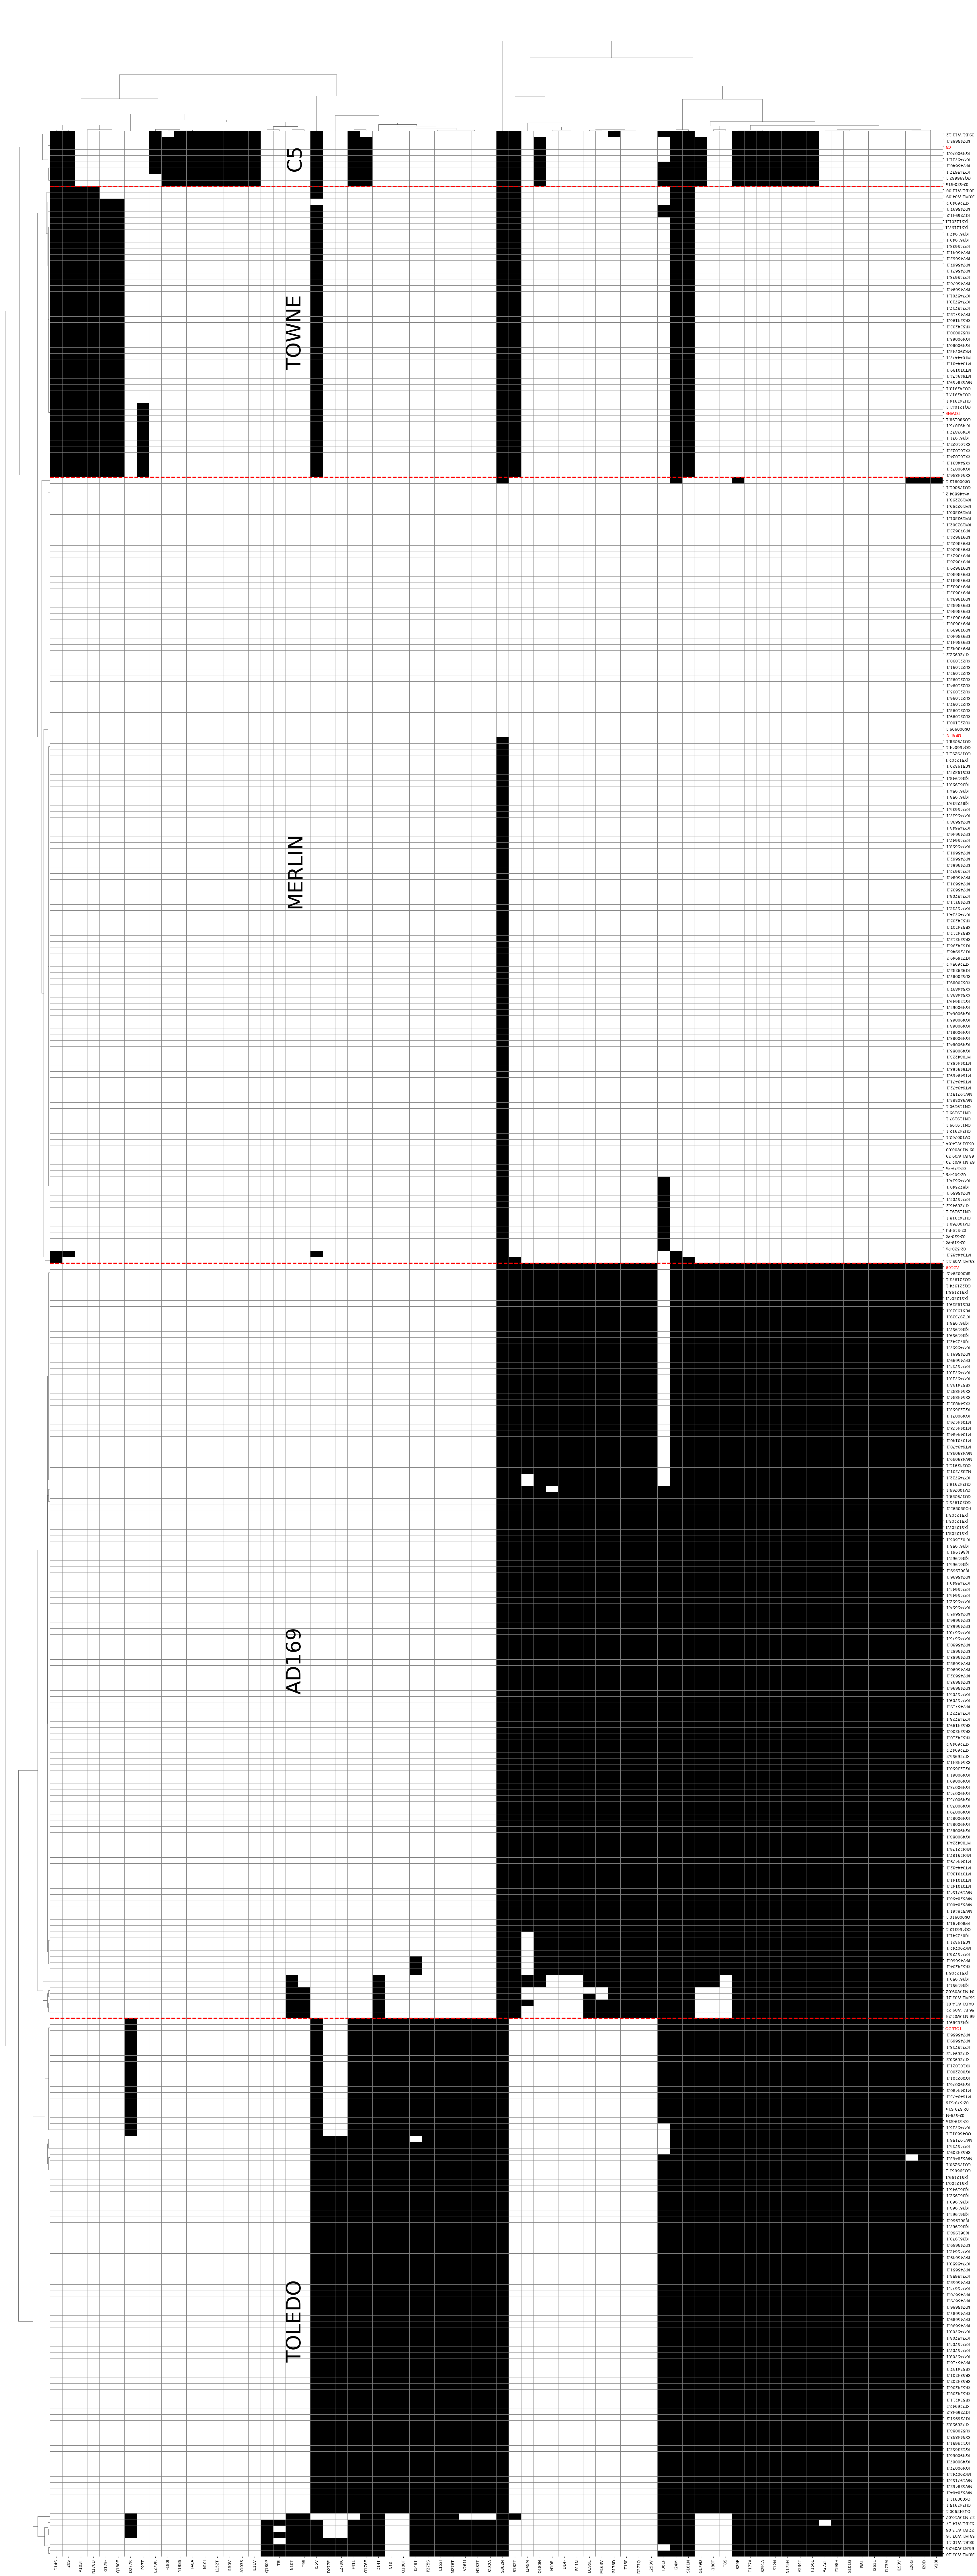

In [ ]:
import sys
import warnings
import pandas as pd
sys.path.append('utils')
import utils
warnings.filterwarnings("ignore", category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt

count = 0
sequence_data = {}
unique_mutations = set()

results = utils.load_data_from_json("data/results/UL33_results.json")
# Assuming 'results' is your dictionary containing the data.
for gene, sequences in results.items():
    # print(gene)
    for description, mutations in sequences.items():
        count += 1
        # Initialize the dictionary for the sequence if it doesn't exist
        if description not in sequence_data:
            sequence_data[description] = {}
        # Initialize the mutation count for all mutations for each sequence, ensures all are present
        for position_kmer, details in mutations.items():
            for mutation in details["amino_acid_changes"]:
                unique_mutations.add(mutation)
                # Initialize this mutation in the sequence's dictionary if it's the first encounter
                if mutation not in sequence_data[description]:
                    sequence_data[description][mutation] = 0
        # Now safely update the count
        for position_kmer, details in mutations.items():
            for mutation in details["amino_acid_changes"]:
                sequence_data[description][mutation] += 1

# Adding sequences with zero mutations to the dictionary
for description in sequence_data:
    existing_mutations = sequence_data[description].keys()
    for mutation in unique_mutations:
        if mutation not in existing_mutations:
            sequence_data[description][mutation] = 0

# Create the DataFrame with unique mutations as columns
df = pd.DataFrame.from_dict(sequence_data, orient='index', columns=sorted(unique_mutations)).fillna(0).astype(int)

# Save the DataFrame to an Excel file
excel_path = 'data/results/mutation_presence_absence_matrix.xlsx'
df.to_excel(excel_path, index=True, index_label='Sequence ID')

# Load the data from the Excel file
file_path = 'data/results/mutation_presence_absence_matrix.xlsx'
data = pd.read_excel(file_path, index_col='Sequence ID')

# Print the number of columns before filtering
print("Number of columns before filtering:", data.shape[1])

# List of columns to remove based on specific unwanted mutations
specific_mutations_to_remove = [
    "T361N", "G184E", "A356T", "T60S", "D360E",
    "T85S", "T8A", "T394A", "T13N", "G179V",
    "C366Y", "L210M", "L402F", "A356S", "T138I",
    "A340V", "V133I", "D360N", "E279G", "S240N"
]

# Identify columns where mutations appear 1 time or fewer across all sequences
cols_with_few_occurrences = data.columns[data.sum(axis=0) <= 1]

# Combine the two lists to remove
columns_to_remove = set(specific_mutations_to_remove) | set(cols_with_few_occurrences)

# Filter columns: Remove specific columns and those with three occurrences or fewer
filtered_data = data.drop(columns=columns_to_remove)

# Print the number of columns after filtering
print("Number of columns after filtering:", filtered_data.shape[1])

# Generate the cluster map with filtered data
plt.figure(figsize=(38, 98))
cluster_map = sns.clustermap(
    filtered_data,
    method='weighted',
    cmap='binary',
    metric='hamming',
    linewidths=0.5,
    mask=None,
    cbar_pos=None,
    linecolor="grey",
    dendrogram_ratio=0.05,
    figsize=(35, 90)
)
plt.setp(cluster_map.ax_heatmap.yaxis.get_majorticklabels(), rotation=180)  # Rotate labels if needed

# Renaming and highlighting specific labels
label_changes = {
    'NC_006273.2': 'MERLIN',
    'FJ616285.1': 'TOWNE',
    'FJ527563.1': 'AD169',
    'GU937742.2': 'TOLEDO',
    'GU180094.1': 'C5'
}

# Update labels
labels = []
majorticklabels = cluster_map.ax_heatmap.yaxis.get_majorticklabels()
for x in majorticklabels:
    label_text = x.get_text().split("|")[0]
    new_label = label_changes.get(label_text, label_text)
    labels.append(new_label)

cluster_map.ax_heatmap.set_yticklabels(labels)
cluster_map.ax_heatmap.set_xlabel('')
cluster_map.ax_heatmap.set_ylabel('')

positions_to_mark = [9, 56, 183, 305]
for pos in positions_to_mark:
    plt.axhline(y=pos, color='red', linestyle='--', linewidth=2.5)  # Change color, linestyle, or width as desired

for label in cluster_map.ax_heatmap.yaxis.get_majorticklabels():
    if label.get_text() in ["MERLIN", "TOWNE", "AD169", "TOLEDO", "C5"]:
        label.set_color('red')

annotations = {
    "C5": (19, 6),
    "TOWNE": (19, 38),
    "MERLIN": (19, 125),
    "AD169": (19, 252),
    "TOLEDO": (19, 360)
}
for label, (x, y) in annotations.items():
    cluster_map.ax_heatmap.text(x, y, f"{label}", color="black", fontsize=50, rotation=90, alpha=1)

# Save the cluster map to a file
cluster_map.savefig('fig/figure_clustermap.pdf')

# Show the plot
plt.show()